In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
from matplotlib import rcParams

In [ ]:
class Experiment():
    def __init__(self, n_options=2, n_trials=50, reward_probs=None, sigma=1, beta=1):
        # Setup experiment
        self.n_options = n_options
        self.n_trials = n_trials
        if reward_probs is not None:
            assert len(reward_probs) == n_options, "Please specify a reward probaility for each option."
            assert all([0 <= r <= 1 for r in reward_probs]), "Values must be probabilies (i.e between 0 and 1)."
        else:
            reward_probs = np.random.rand(n_options).tolist()
        self.reward_probs = reward_probs
        self.sigma = sigma
        self.beta = beta

        # Initialize parameters
        self.avals, self.bvals = np.ones((n_trials+1, n_options)), np.ones((n_trials+1, n_options))
        self.Ms = np.zeros((n_trials, n_options)) # expected reward probability (mean of beta distribution)
        self.Vs = np.zeros((n_trials, n_options)) # reward uncertainty (variance of beta distribution)
        self.Qs = np.zeros((n_trials, n_options)) # decision value
        self.Ps = np.zeros((n_trials, n_options)) # choice probabilities
        self.choices = np.zeros(n_trials, dtype=np.int32)
        self.rewards = np.zeros(n_trials, dtype=np.int32)

        # state machine
        self.experiment_complete = False

    def run_experiment(self):
        #print("Running experiment")
        for i in range(self.n_trials):
            self.simulate_single_trial(i)
        self.experiment_complete = True
        #print("Experiment complete!")

        return dict(
                Ps=self.Ps,
                Ms=self.Ms,
                Vs=self.Vs,
                Qs=self.Qs,
                choices=self.choices,
                rewards=self.rewards,
                reward_probs=self.reward_probs,
                avals=self.avals,
                bvals=self.bvals,
                )

    def simulate_single_trial(self, i):
        # Compute policy
        aval = self.avals[i]
        bval = self.bvals[i]
        self.Ms[i] = aval / (aval + bval) # belief or expected reward probability (mean of beta distribution)
        self.Vs[i] = (aval*bval) / ((aval + bval)**2 * (aval + bval + 1)) # reward uncertainty (variance of beta distribution)
        self.Qs[i] = self.Ms[i] + self.sigma*self.Vs[i] # decision value
        self.Ps[i] = np.exp(self.beta*self.Qs[i]) / np.sum(np.exp(self.beta*self.Qs[i])) # action policy

        # Make a choice
        choice = np.random.choice(np.arange(self.n_options), p=self.Ps[i])
        self.rewards[i] = np.random.binomial(1, self.reward_probs[choice])
        self.choices[i] = choice

        # Update beta distribution parameters
        self.avals[i+1] = self.avals[i]
        self.bvals[i+1] = self.bvals[i]
        if self.rewards[i] > 0:
            self.avals[i+1, choice] = self.avals[i, choice] + 1
        else:
            self.bvals[i+1, choice] = self.bvals[i, choice] + 1


In [ ]:
sigma = 3
beta = 5
n_trials = 200
# reward_probs = None
reward_probs = [0.8, 0.6, 0.4, 0.2]
n_options = len(reward_probs)

exp = Experiment(n_options=n_options, n_trials=n_trials, reward_probs=reward_probs, sigma=sigma, beta=beta)
res = exp.run_experiment()

[0.8, 0.6, 0.4, 0.2]
[107, 31, 52, 10]
Ps [[0.62812944 0.17331939 0.16701878 0.03153239]
 [0.63030542 0.17230522 0.16604148 0.03134788]
 [0.6324364  0.17131203 0.16508439 0.03116718]
 [0.63452367 0.17033921 0.16414693 0.03099019]
 [0.62658631 0.18071758 0.16209359 0.03060253]]


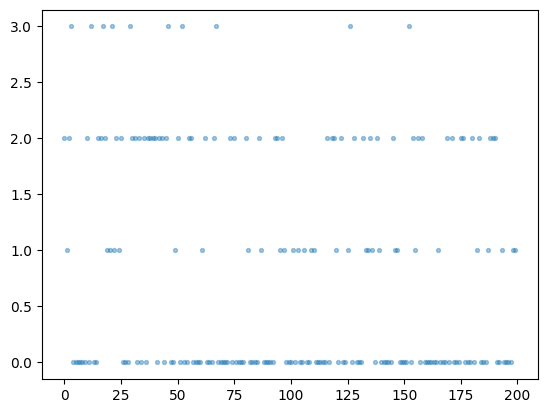

In [ ]:
print(res['reward_probs'])

plt.scatter(np.arange(n_trials), res['choices'], s=8, alpha=0.4)
print([np.sum(res['choices'] == i) for i in range(n_options)])
print("Ps", res['Ps'][-5:])
# print("Qs")
# print(res['Qs'])
# print("as")
# print(res['avals'])
# print("bs")
# print(res['bvals'])
# print('rewards')
# print(res['rewards'])

### Problem 1

In [ ]:
# Compute entropy
def entropy(distribution):
    """
    Compute the entropy of a distribution.
    
    Parameters:
        distribution (array-like): The input distribution.
        
    Returns:
        float: The entropy of the distribution.
    """
    # Compute entropy
    entropy_val = -np.sum(distribution * np.log(distribution), axis=1)

    return entropy_val

In [ ]:
# sliding window averaging

def sliding_window_avg(measure, n_avg, sem=None):
    """
    Returns a sliding window average of a measure over n_avg epochs.
    measure_sw[0] is the mean, measure_sw[1] is the SEM.
        The SEM is computed from standard deviation over the window OR from the 
        individual SEMs if provided.
    """
    n_steps = measure.shape[0] - n_avg
    measure_sw = np.zeros((2, n_steps))
    for i in range(n_steps):
        measure_sw[0, i] = np.mean(measure[i:i+n_avg])
        if sem is not None:
            measure_sw[1, i] = np.sqrt(np.mean(sem[i:i+n_avg]**2))
        else:
            measure_sw[1, i] = np.std(measure[i:i+n_avg])/np.sqrt(n_avg)

    return measure_sw

(200,)


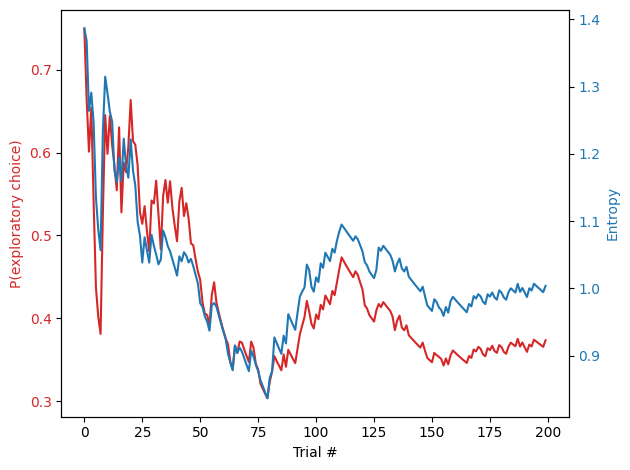

In [ ]:
# PROBLEM 1
# Assumption: entropy of the softmax policy is proportional to baseline pupil diameter
# TODO: Plot proportion of exploratory choices over time bins & entropy of action distribution over time

# suboptimal = (res['choices'] != 0).reshape(-1, 100).mean(axis=1)
# suboptimal = (res['choices'] != np.argmax(res['Ms'], axis=1)[0]).reshape(-1, 10).mean(axis=1)

Ps = res['Ps']
entropies = entropy(Ps)

best_option = np.argmax(res['Ms'], axis=1) # option with highest expected payoff
print(best_option.shape)
exploratory = np.array([1 - Ps[i, best_option[i]] for i in range(n_trials)]) # probability of an exploratory choice

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Trial #')
ax1.set_ylabel('P(exploratory choice)', color=color)
ax1.plot(np.arange(n_trials), exploratory, color=color, label='P(exploratory choice)')
ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Entropy', color=color)  # we already handled the x-label with ax1
ax2.plot(entropies, label='entropy', color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



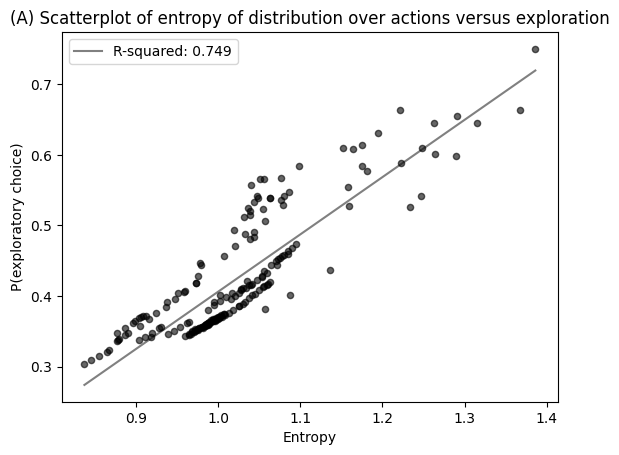

In [ ]:
plt.scatter(entropies, exploratory, s=20, alpha=0.6, c='k')
plt.xlabel('Entropy')
plt.ylabel('P(exploratory choice)')

reg = st.linregress(entropies, exploratory)
x = np.linspace(min(entropies), max(entropies), 50)
plt.plot(x, x*reg.slope+reg.intercept, c='grey', zorder=0, label=f"R-squared: {reg.rvalue**2:.3f}")
plt.title('(A) Scatterplot of entropy of distribution over actions versus exploration')
plt.legend()


[1 2 3 4 5 6 7 8 9]
[0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25]
0.8791777979566642


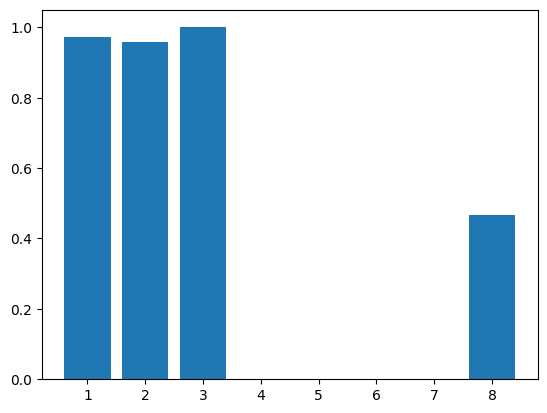

In [ ]:
# tried to show directly from choices, noisy
ebins = np.arange(0.85, 1.3, 0.05)
entropies_binned = np.digitize(entropies, ebins)
unique_eb = np.unique(entropies_binned)
best_option = np.argmax(res['Ms'], axis=1)
explore_eb = np.zeros(unique_eb.shape[0])

for i in range(unique_eb.shape[0]):
    inds = np.where(unique_eb[i]==entropies_binned)[0]
    choices_i = res['choices'][inds]
    n_explore_i = np.count_nonzero(choices_i != best_option[i])
    if n_explore_i >= 5:
        explore_eb[i] = n_explore_i/inds.shape[0]
    else:
        explore_eb[i] = None

fig, ax = plt.subplots(1,1)
ax.bar(np.arange(explore_eb.shape[0]), explore_eb)

print(unique_eb)
print(ebins)
print(np.min(entropies))

### Problem 2

In [ ]:
# PROBLEM 2
# TODO: Set sigma to zero and run simulation, plot results

# TODO: Hand-engineer choices such that the mean of the beta distributions are the same,
#       but the variances are different. Show that the policy is biased towards the higher-variance 
#       Could maybe just explain this conceptually, not necessarily implement code

In [ ]:
# time-varying reward probs version
class Experiment_timeVaryingProbs(Experiment):
    def __init__(self, reward_probs, n_options=2, n_trials=50, sigma=1, beta=1):
        self.reward_probs = reward_probs
        self.n_options = n_options
        self.n_trials = n_trials
        self.sigma = sigma
        self.beta = beta
        assert reward_probs.shape == (n_trials, n_options), 'reward_probs must be an n_trials by n_options array'

        # Initialize parameters
        self.avals, self.bvals = np.ones((n_trials+1, n_options)), np.ones((n_trials+1, n_options))
        self.Ms = np.zeros((n_trials, n_options)) # expected reward probability (mean of beta distribution)
        self.Vs = np.zeros((n_trials, n_options)) # reward uncertainty (variance of beta distribution)
        self.Qs = np.zeros((n_trials, n_options)) # decision value
        self.Ps = np.zeros((n_trials, n_options)) # choice probabilities
        self.choices = np.zeros(n_trials, dtype=np.int32)
        self.rewards = np.zeros(n_trials, dtype=np.int32)

        # state machine
        self.experiment_complete = False
    
    def simulate_single_trial(self, i):
        # Compute policy
        aval = self.avals[i]
        bval = self.bvals[i]
        self.Ms[i] = aval / (aval + bval) # belief or expected reward probability (mean of beta distribution)
        self.Vs[i] = (aval*bval) / ((aval + bval)**2 * (aval + bval + 1)) # reward uncertainty (variance of beta distribution)
        self.Qs[i] = self.Ms[i] + self.sigma*self.Vs[i] # decision value
        self.Ps[i] = np.exp(self.beta*self.Qs[i]) / np.sum(np.exp(self.beta*self.Qs[i])) # action policy

        # Make a choice
        choice = np.random.choice(np.arange(self.n_options), p=self.Ps[i])
        self.rewards[i] = np.random.binomial(1, self.reward_probs[i, choice]) # change is here
        self.choices[i] = choice

        # Update beta distribution parameters
        self.avals[i+1] = self.avals[i]
        self.bvals[i+1] = self.bvals[i]
        if self.rewards[i] > 0:
            self.avals[i+1, choice] = self.avals[i, choice] + 1
        else:
            self.bvals[i+1, choice] = self.bvals[i, choice] + 1

Text(0, 0.5, 'Difference in choice probabilities')

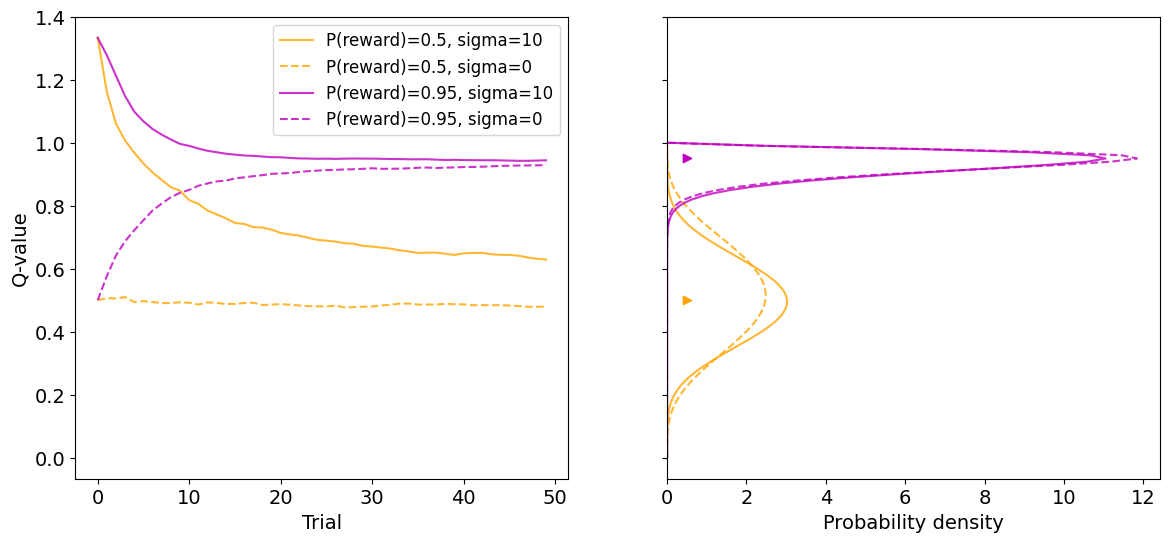

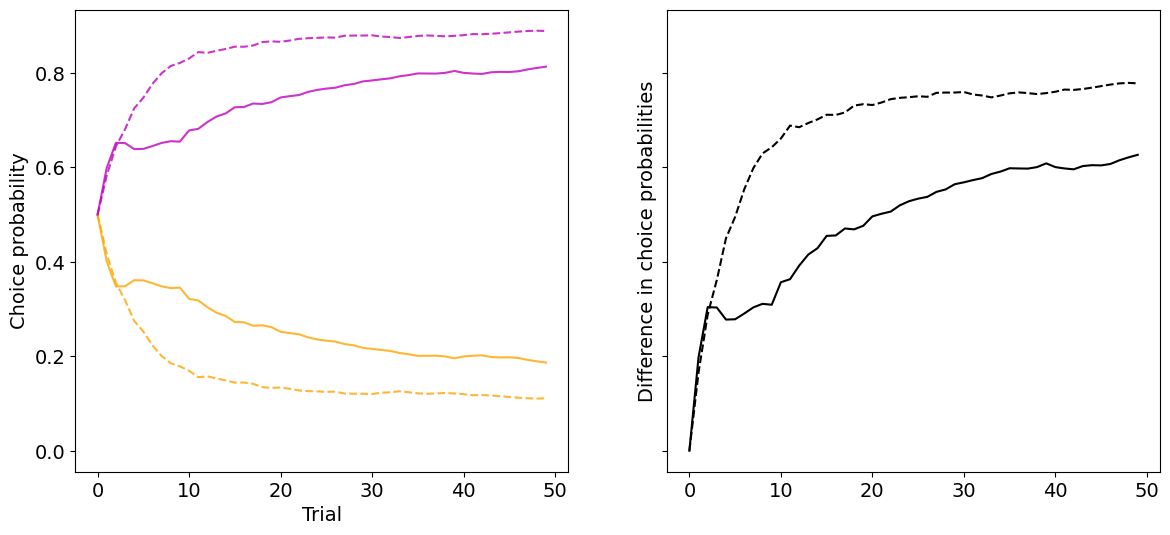

In [ ]:
# Set sigma to zero and run simulation, plot results, compare: stationary reward_probs

beta = 5
n_trials = 50
reward_probs = [0.5, 0.95]
n_options = len(reward_probs)

sigma1 = 10
sigma2 = 0

exp1 = Experiment(n_options=n_options, n_trials=n_trials, reward_probs=reward_probs, sigma=sigma1, beta=beta)
exp2 = Experiment(n_options=n_options, n_trials=n_trials, reward_probs=reward_probs, sigma=sigma2, beta=beta)

N_sims = 100
Qs1, Ps1 = np.zeros((n_trials, n_options, N_sims)), np.zeros((n_trials, n_options, N_sims))
Qs2, Ps2 = np.zeros((n_trials, n_options, N_sims)), np.zeros((n_trials, n_options, N_sims))
last_avals1 = np.zeros((n_options, N_sims))
last_avals2 = np.zeros((n_options, N_sims))
last_bvals1 = np.zeros((n_options, N_sims))
last_bvals2 = np.zeros((n_options, N_sims))

for i in range(N_sims):
    res1 = exp1.run_experiment()
    res2 = exp2.run_experiment()
    Qs1[...,i] = res1['Qs']
    Qs2[...,i] = res2['Qs']
    Ps1[...,i] = res1['Ps']
    Ps2[...,i] = res2['Ps']
    last_avals1[...,i] = res1['avals'][-1]
    last_avals2[...,i] = res2['avals'][-1]
    last_bvals1[...,i] = res1['bvals'][-1]
    last_bvals2[...,i] = res2['bvals'][-1]

colors = ['orange', 'm', 'dodgerblue', 'limegreen']
x = np.arange(0, 1.01, 0.01)
fig1, ax1 = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
fig2, ax2 = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i in range(n_options):
    ax1[0].plot(np.arange(n_trials), np.mean(Qs1[:,i,:], axis=1), 
                color=colors[i], alpha=0.8, label=f'P(reward)={reward_probs[i]}, sigma={sigma1}')
    ax1[0].plot(np.arange(n_trials), np.mean(Qs2[:,i,:], axis=1), 
                color=colors[i], ls='--', alpha=0.8, label=f'P(reward)={reward_probs[i]}, sigma={sigma2}')
    #ax1[0].hlines(reward_probs[i], 0, n_trials, color=colors[i], alpha=0.4)

    ax1[1].scatter(0.5, reward_probs[i], color=colors[i], marker='>')
    rv1 = st.beta(np.mean(last_avals1[i,:]), np.mean(last_bvals1[i,:]))
    ax1[1].plot(rv1.pdf(x), x, color=colors[i], alpha=0.8)
    rv2 = st.beta(np.mean(last_avals2[i,:]), np.mean(last_bvals2[i,:]))
    ax1[1].plot(rv2.pdf(x), x, color=colors[i], ls='--', alpha=0.8)

    ax2[0].plot(np.arange(n_trials), np.mean(Ps1[:,i,:], axis=1), color=colors[i], alpha=0.8)
    ax2[0].plot(np.arange(n_trials), np.mean(Ps2[:,i,:], axis=1), color=colors[i], ls='--', alpha=0.8)

ax1[0].legend(fontsize=12)
ax1[1].set_xlim(0,)

ax2[1].plot(np.arange(n_trials), np.mean(Ps1[:,1,:], axis=1) - np.mean(Ps1[:,0,:], axis=1), color='k')
ax2[1].plot(np.arange(n_trials), np.mean(Ps2[:,1,:], axis=1) - np.mean(Ps2[:,0,:], axis=1), ls='--', color='k')

rcParams['font.size'] = 14
ax1[0].set_xlabel('Trial')
ax1[0].set_ylabel('Q-value')
ax1[1].set_xlabel('Probability density')

ax2[0].set_xlabel('Trial')
ax2[0].set_ylabel('Choice probability')
ax2[1].set_ylabel('Difference in choice probabilities')

Text(0.5, 0, 'Probability density')

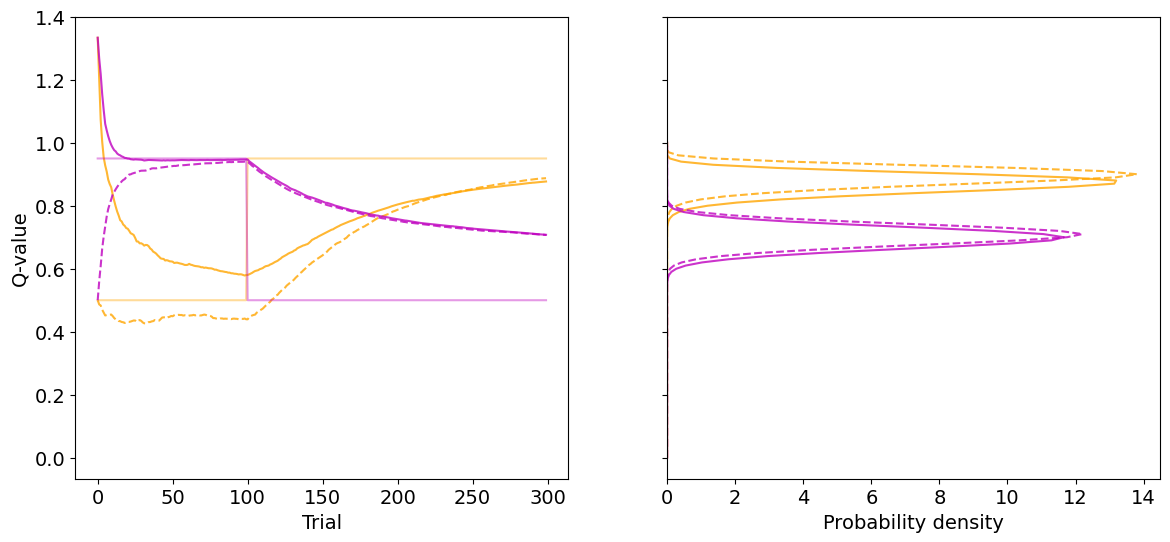

In [ ]:
# Set sigma to zero and run simulation, plot results, compare: switching reward_probs

beta = 5
n_options = 2
n_trials = 300
t_switch = 100
reward_probs = np.zeros((n_trials, n_options))
reward_probs[:t_switch, 0] = 0.5
reward_probs[t_switch:, 0] = 0.95
reward_probs[:t_switch, 1] = 0.95
reward_probs[t_switch:, 1] = 0.5

sigma1 = 10
sigma2 = 0

exp1 = Experiment_timeVaryingProbs(
        n_options=n_options, n_trials=n_trials, reward_probs=reward_probs, sigma=sigma1, beta=beta)
exp2 = Experiment_timeVaryingProbs(
        n_options=n_options, n_trials=n_trials, reward_probs=reward_probs, sigma=sigma2, beta=beta)

N_sims = 100
Qs1 = np.zeros((n_trials, n_options, N_sims))
Qs2 = np.zeros((n_trials, n_options, N_sims))
last_avals1 = np.zeros((n_options, N_sims))
last_avals2 = np.zeros((n_options, N_sims))
last_bvals1 = np.zeros((n_options, N_sims))
last_bvals2 = np.zeros((n_options, N_sims))

for i in range(N_sims):
    res1 = exp1.run_experiment()
    res2 = exp2.run_experiment()
    Qs1[...,i] = res1['Qs']
    Qs2[...,i] = res2['Qs']
    last_avals1[...,i] = res1['avals'][-1]
    last_avals2[...,i] = res2['avals'][-1]
    last_bvals1[...,i] = res1['bvals'][-1]
    last_bvals2[...,i] = res2['bvals'][-1]

colors = ['orange', 'm', 'dodgerblue', 'limegreen']
x = np.arange(0, 1.01, 0.01)
fig, ax = plt.subplots(1,2, figsize=(14, 6), sharey=True)

for i in range(n_options):
    
    ax[0].plot(np.arange(n_trials), np.mean(Qs1[:,i,:], axis=1), color=colors[i], alpha=0.8)
    ax[0].plot(np.arange(n_trials), np.mean(Qs2[:,i,:], axis=1), color=colors[i], ls='--', alpha=0.8)
    ax[0].plot(np.arange(n_trials), reward_probs[:,i], color=colors[i], alpha=0.4)

    rv1 = st.beta(np.mean(last_avals1[i,:]), np.mean(last_bvals1[i,:]))
    ax[1].plot(rv1.pdf(x), x, color=colors[i], alpha=0.8)
    rv2 = st.beta(np.mean(last_avals2[i,:]), np.mean(last_bvals2[i,:]))
    ax[1].plot(rv2.pdf(x), x, color=colors[i], ls='--', alpha=0.8)

ax[1].set_xlim(0,)

rcParams['font.size'] = 14
ax[0].set_xlabel('Trial')
ax[0].set_ylabel('Q-value')
ax[1].set_xlabel('Probability density')

In [ ]:
Ps = res['Ps']

best_option = np.argmax(np.array(reward_probs))
suboptimal = 1 - Ps[:,best_option] # probability of a suboptimal choice

n_avg = 10
x_sw = np.arange(n_avg/2, n_trials-n_avg/2)
suboptimal_sw = sliding_window_avg(suboptimal, n_avg)

plt.plot(x_sw, suboptimal_sw[0])

plt.plot(entropy(Ps))

### Problem 3

In [ ]:
# PROBLEM 3
# TODO: Define a novelty bonus, as (Gamma) * 1 / np.sqrt(# of past choices of this option)
#       Add it to Q(i), instead of the uncertainty bonus
#       Check that the novelty bonus behaves similarly to uncertainty bonus

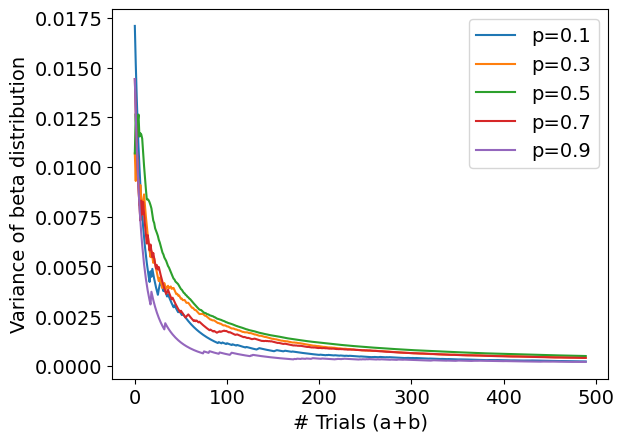

In [ ]:
ps = np.arange(1,10,2) * 0.1
n_trials = 500
variances = np.zeros((9, n_trials))
for i, p in enumerate(ps):
    samples = np.random.binomial(1, p, size=(n_trials))
    avals = np.cumsum(samples) + 1
    bvals = np.arange(n_trials) - avals + 2
    variances[i] = (avals * bvals) / ((avals + bvals)**2 * (avals + bvals + 1))
    plt.plot(variances[i, 10:], label="p={:0.1}".format(p))

plt.xlabel("# Trials (a+b)")
plt.ylabel("Variance of beta distribution")
plt.legend()

In [ ]:
class ExperimentNovelty():
    def __init__(self, n_options=2, n_trials=50, reward_probs=None, sigma=0, beta=1, gamma=1):
        # Setup experiment
        self.n_options = n_options
        self.n_trials = n_trials
        if reward_probs is not None:
            assert len(reward_probs) == n_options, "Please specify a reward probaility for each option."
            assert all([0 <= r <= 1 for r in reward_probs]), "Values must be probabilies (i.e between 0 and 1)."
        else:
            reward_probs = np.random.rand(n_options).tolist()
        self.reward_probs = reward_probs
        self.sigma = sigma
        self.beta = beta
        self.gamma = gamma # novelty bonus

        # Initialize parameters
        self.avals, self.bvals = np.ones((n_trials+1, n_options)), np.ones((n_trials+1, n_options))
        self.Ms = np.zeros((n_trials, n_options)) # expected reward probability (mean of beta distribution)
        self.Vs = np.zeros((n_trials, n_options)) # reward uncertainty (variance of beta distribution)
        self.Qs = np.zeros((n_trials, n_options)) # decision value
        self.Ps = np.zeros((n_trials, n_options)) # choice probabilities
        self.Ns = np.zeros((n_trials, n_options)) # novelty bonus
        self.choices = np.zeros(n_trials, dtype=np.int32)
        self.rewards = np.zeros(n_trials, dtype=np.int32)

        # state machine
        self.experiment_complete = False

    def run_experiment(self):
        #print("Running experiment")
        for i in range(self.n_trials):
            self.simulate_single_trial(i)
        self.experiment_complete = True
        #print("Experiment complete!")

        return dict(
                Ps=self.Ps,
                Ms=self.Ms,
                Vs=self.Vs,
                Qs=self.Qs,
                Ns=self.Ns,
                choices=self.choices,
                rewards=self.rewards,
                reward_probs=self.reward_probs,
                avals=self.avals,
                bvals=self.bvals,
                )

    def novelty_bonus(self, i):
        return 1 / np.sqrt(np.array([np.sum(self.choices[:i] == option) for option in range(self.n_options)])+0.1)

    def simulate_single_trial(self, i):
        # Compute policy
        aval = self.avals[i]
        bval = self.bvals[i]
        self.Ms[i] = aval / (aval + bval) # belief or expected reward probability (mean of beta distribution)
        self.Vs[i] = (aval*bval) / ((aval + bval)**2 * (aval + bval + 1)) # reward uncertainty (variance of beta distribution)
        self.Ns[i] = self.novelty_bonus(i)
        self.Qs[i] = self.Ms[i] + self.sigma*self.Vs[i] + self.gamma*self.Ns[i] # decision value
        self.Ps[i] = np.exp(self.beta*self.Qs[i]) / np.sum(np.exp(self.beta*self.Qs[i])) # action policy

        # Make a choice
        choice = np.random.choice(np.arange(self.n_options), p=self.Ps[i])
        self.rewards[i] = np.random.binomial(1, self.reward_probs[choice])
        self.choices[i] = choice

        # Update beta distribution parameters
        self.avals[i+1] = self.avals[i]
        self.bvals[i+1] = self.bvals[i]
        if self.rewards[i] > 0:
            self.avals[i+1, choice] = self.avals[i, choice] + 1
        else:
            self.bvals[i+1, choice] = self.bvals[i, choice] + 1


In [ ]:
sigma = 0
beta = 5
gamma = 1
n_trials = 200
# reward_probs = None
reward_probs = np.arange(1,10,2) * 0.1 #[0.8, 0.6, 0.4, 0.2]
n_options = len(reward_probs)

exp = ExperimentNovelty(n_options=n_options, n_trials=n_trials, reward_probs=reward_probs, sigma=sigma, beta=beta, gamma=gamma)
res3 = exp.run_experiment()

(200,)


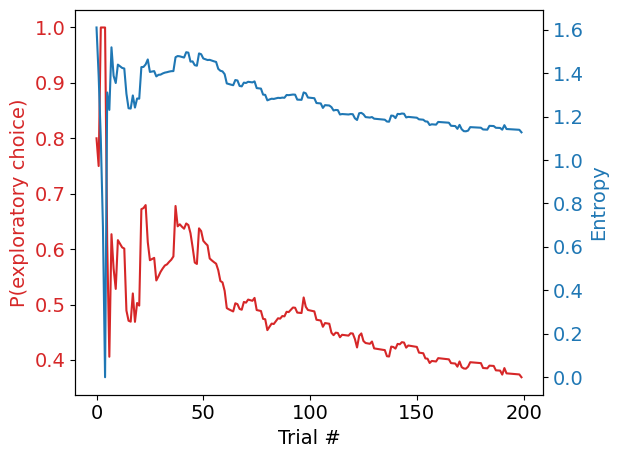

In [ ]:
# PROBLEM 1
# Assumption: entropy of the softmax policy is proportional to baseline pupil diameter
# TODO: Plot proportion of exploratory choices over time bins & entropy of action distribution over time

# suboptimal = (res['choices'] != 0).reshape(-1, 100).mean(axis=1)
# suboptimal = (res['choices'] != np.argmax(res['Ms'], axis=1)[0]).reshape(-1, 10).mean(axis=1)

Ps = res3['Ps']
entropies = entropy(Ps)

best_option = np.argmax(res3['Ms'], axis=1) # option with highest expected payoff
print(best_option.shape)
exploratory = np.array([1 - Ps[i, best_option[i]] for i in range(n_trials)]) # probability of an exploratory choice

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Trial #')
ax1.set_ylabel('P(exploratory choice)', color=color)
ax1.plot(np.arange(n_trials), exploratory, color=color, label='P(exploratory choice)')
ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Entropy', color=color)  # we already handled the x-label with ax1
ax2.plot(entropies, label='entropy', color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



Text(0, 0.5, 'Novelty Bonus')

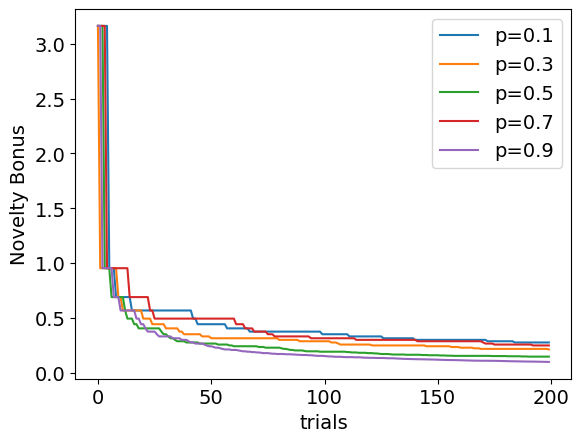

In [ ]:
for i in range(n_options):
    plt.plot(res3['Ns'][:,i], label="p={:0.1}".format(reward_probs[i]))

plt.legend()
plt.xlabel('trials')
plt.ylabel('Novelty Bonus')

In [ ]:
sigma = 5
beta = 5
gamma = 0
n_trials = 200
# reward_probs = None
reward_probs = np.arange(1,10,2) * 0.1 #[0.8, 0.6, 0.4, 0.2]
n_options = len(reward_probs)

exp = ExperimentNovelty(n_options=n_options, n_trials=n_trials, reward_probs=reward_probs, sigma=sigma, beta=beta, gamma=gamma)
res4 = exp.run_experiment()

(200,)


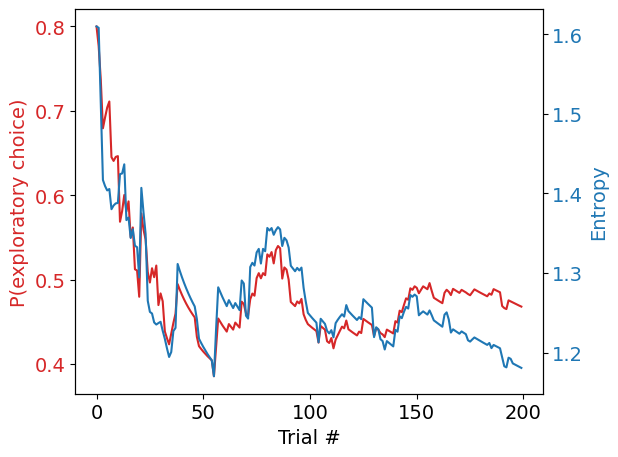

In [ ]:
# PROBLEM 1
# Assumption: entropy of the softmax policy is proportional to baseline pupil diameter
# TODO: Plot proportion of exploratory choices over time bins & entropy of action distribution over time

# suboptimal = (res['choices'] != 0).reshape(-1, 100).mean(axis=1)
# suboptimal = (res['choices'] != np.argmax(res['Ms'], axis=1)[0]).reshape(-1, 10).mean(axis=1)

Ps = res4['Ps']
entropies = entropy(Ps)

best_option = np.argmax(res4['Ms'], axis=1) # option with highest expected payoff
print(best_option.shape)
exploratory = np.array([1 - Ps[i, best_option[i]] for i in range(n_trials)]) # probability of an exploratory choice

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Trial #')
ax1.set_ylabel('P(exploratory choice)', color=color)
ax1.plot(np.arange(n_trials), exploratory, color=color, label='P(exploratory choice)')
ax1.tick_params(axis='y', labelcolor=color)
# ax1.legend()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Entropy', color=color)  # we already handled the x-label with ax1
ax2.plot(entropies, label='entropy', color=color)
ax2.tick_params(axis='y', labelcolor=color)
# ax2.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()



Text(0, 0.5, 'Uncertainty Bonus')

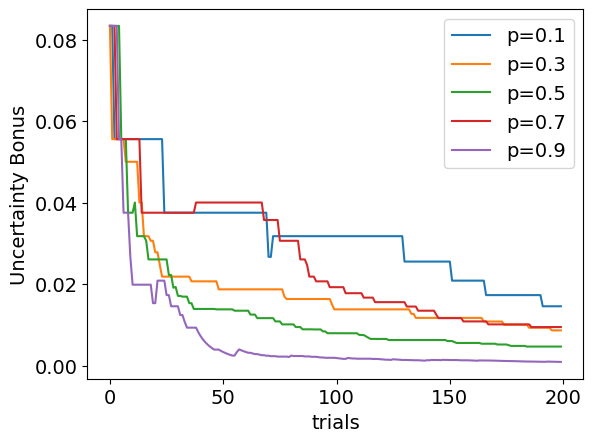

In [ ]:
for i in range(n_options):
    plt.plot(res4['Vs'][:,i], label="p={:0.1}".format(reward_probs[i]))

plt.legend()
plt.xlabel('trials')
plt.ylabel('Uncertainty Bonus')

### Additional

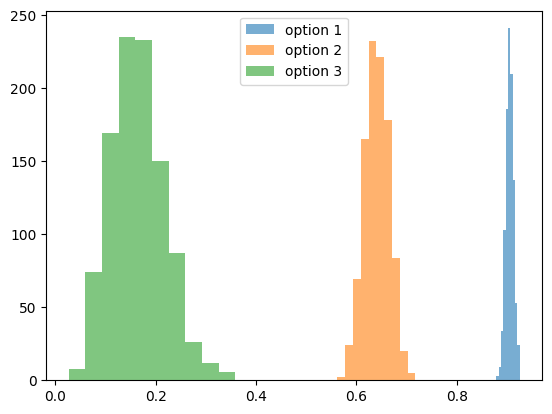

In [ ]:
# beta parameters after learning

a_last = res['avals'][-1,:]
b_last = res['bvals'][-1,:]

plt.figure()
for i in range(a_last.shape[0]):
    beta_i = st.beta(a_last[i], b_last[i]).rvs(size=1000)
    plt.hist(beta_i, label=f'option {i+1}', alpha=0.6)
plt.legend()

In [ ]:
'''
def simulate_experiment(n_options=2, n_trials=5, reward_probs=None, sigma=1, beta=1):
    """
    Args:
        n_options: number of options to choose from
        n_trials: number of trials agent acts for
        reward_probs: specify reward probailities for each option.
                        randomly initializes if None.
        sigma: uncertainty bonus weight (variance)
        beta: softmax slope weight (temperature)

    Returns:
        dict: {
                'action_policy': The probability of each action (Go/No-Go) after updating belief. P in model.
                'beta_parameters': Parameters (a,b) of the learned beta distribution for each option.
                'model_values': Returns the M, V, Q, and P values of each opton.
                'observations': The actual observations for each trial in the experiment.
                'posterior_belief': The agent's updated belief about the reward distribution. M in model.
                'reward_probability': The true reward probability of each option. 
                }
    """

    # Give each option some probability of observing a reward
    if reward_probs is not None:
        assert len(reward_probs) == n_options, "Please specify a reward probaility for each option."
        assert all([0 <= r <= 1 for r in reward_probs]), "Values must be probabilies (i.e between 0 and 1)."
    else:
        reward_probs = np.random.rand(n_options).tolist()
    print("TRUE (unobserved) prob. of reward for each option:\n\t", reward_probs, end="\n\n")

    a, b = np.ones(n_options), np.ones(n_options)
    # Each option i is assigned a decision value according to Q(i) = M(i) + σ*V(i)
    M = [a[i] / (a[i] + b[i]) for i in range(n_options)] 
    V = [(a[i] * b[i]) / ((a[i] + b[i])**2 * (a[i] + b[i] + 1)) for i in range(n_options)] # reward uncertainty (variance of beta distribution)
    Q = [M[i] + sigma * V[i] for i in range(n_options)] # decision value
    P = [np.exp(beta * Q[i]) / np.sum(np.exp(beta*Q)) for i in range(n_options)] # action policy
    print("BEFORE observation")
    print("\tBelief of reward for each option:\t", M)
    print("\tProb. of GO for each option:\t", P, end="\n\n")

    # Sample a certain number of trials (i.e. observe whether reward/no reward for each option)
    observations = [st.bernoulli(reward_probs).rvs().tolist() for _ in range(n_trials)]
    if n_trials <= 0:
        print("No trials were run!")
    else:
        print("Observation of reward for each option:") 
        for t, obs in enumerate(observations): 
            if t < 3 or t > len(observations) - 4:
                print("\tTrial: %s, Observation: %s"%(t+1, obs))
            elif t == 3:
                print("\t\t...")
    print("", end="\n\n")

    # To see the results before any updates one could enter n_trials=0 
    if n_trials <= 0:
        return dict(
                    action_policy=P,
                    beta_parameters=[(a[i], b[i]) for i in range(n_options)],
                    model_values={'M': M, 'V': V, 'Q': Q, 'P': P},
                    observations={t+1: observations[t] for t in range(n_trials)},
                    posterior_belief=M, 
                    reward_probability=reward_probs, 
                    )  

    # Update the parameters based on the observations
    for t in range(n_trials):
        obs = observations[t]
        for j in range(n_options):
            # whenever a reward is observed, a’ = a + 1
            if obs[j] > 0:
                a[j] += 1
            # whenever a reward is not observed, b’ = b + 1
            else:
                b[j] += 1

    # Update the model given the new parameters
    M = [a[i] / (a[i] + b[i]) for i in range(n_options)] # belief or expected reward probability (mean of beta distribution)
    V = [(a[i] * b[i]) / ((a[i] + b[i])**2 * (a[i] + b[i] + 1)) for i in range(n_options)] # reward uncertainty (variance of beta distribution)
    Q = [M[i] + sigma * V[i] for i in range(n_options)] # decision value
    P = [np.exp(beta * Q[i]) / np.sum(np.exp(beta*Q)) for i in range(n_options)] # action policy
    print("AFTER observation") 
    print("\tBelief of reward for each option:\t", M)
    print("\tProb. of GO for each option:\t", P, end="\n\n")

    # Return the updated model
    return dict(
                action_policy=P,
                beta_parameters=[(a[i], b[i]) for i in range(n_options)],
                model_values={'M': M, 'V': V, 'Q': Q, 'P': P},
                observations={t+1: observations[t] for t in range(n_trials)},
                posterior_belief=M, 
                reward_probability=reward_probs, 
                )
'''

In [ ]:
sim = simulate_experiment(n_options=n_options, n_trials=50, reward_probs=[0.3, 0.5, 0.7], sigma=1, beta=1)
sim.keys()

TRUE (unobserved) prob. of reward for each option:
	 [0.3, 0.5, 0.7]

BEFORE observation
	Belief of reward for each option:	 [0.5, 0.5, 0.5]
	Prob. of GO for each option:	 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

Observation of reward for each option:
	Trial: 1, Observation: [0, 0, 1]
	Trial: 2, Observation: [1, 1, 1]
	Trial: 3, Observation: [0, 0, 1]
	Trial: 4, Observation: [0, 1, 1]
	Trial: 5, Observation: [1, 0, 0]
	Trial: 6, Observation: [1, 1, 1]
	Trial: 7, Observation: [1, 0, 1]
	Trial: 8, Observation: [0, 1, 1]
	Trial: 9, Observation: [1, 1, 1]
	Trial: 10, Observation: [1, 0, 0]
	Trial: 11, Observation: [0, 0, 0]
	Trial: 12, Observation: [0, 0, 1]
	Trial: 13, Observation: [0, 0, 0]
	Trial: 14, Observation: [0, 0, 1]
	Trial: 15, Observation: [0, 1, 1]
	Trial: 16, Observation: [0, 0, 0]
	Trial: 17, Observation: [0, 0, 1]
	Trial: 18, Observation: [0, 0, 1]
	Trial: 19, Observation: [1, 1, 0]
	Trial: 20, Observation: [1, 0, 0]
	Trial: 21, Observation: [0, 1, 1]
	

dict_keys(['action_policy', 'beta_parameters', 'model_values', 'observations', 'posterior_belief', 'reward_probability'])

In [ ]:
# SIMULATE EXPERIMENT WITH DEFAULT ARGUMENTS
# result = simulate_experiment()
# result = simulate_experiment(n_trials=0)
result = simulate_experiment(n_trials=10, reward_probs=[0.5, 0.5, 0.5])
result

TRUE (unobserved) prob. of reward for each option:
	 [0.5, 0.5, 0.5]

BEFORE observation
	Belief of reward for each option:	 [0.5, 0.5, 0.5]
	Prob. of GO for each option:	 [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

Observation of reward for each option:
	Trial: 1, Observation: [1, 1, 1]
	Trial: 2, Observation: [1, 0, 0]
	Trial: 3, Observation: [1, 0, 1]
		...
	Trial: 8, Observation: [0, 0, 1]
	Trial: 9, Observation: [0, 1, 0]
	Trial: 10, Observation: [1, 0, 0]


AFTER observation
	Belief of reward for each option:	 [0.6666666666666666, 0.4166666666666667, 0.4166666666666667]
	Prob. of GO for each option:	 [0.3906097839647793, 0.3046951080176103, 0.3046951080176103]



{'action_policy': [0.3906097839647793, 0.3046951080176103, 0.3046951080176103],
 'beta_parameters': [(8, 4), (5, 7), (5, 7)],
 'model_values': {'M': [0.6666666666666666,
   0.4166666666666667,
   0.4166666666666667],
  'V': [0.017094017094017096, 0.018696581196581196, 0.018696581196581196],
  'Q': [0.6837606837606838, 0.43536324786324787, 0.43536324786324787],
  'P': [0.3906097839647793, 0.3046951080176103, 0.3046951080176103]},
 'observations': {1: [1, 1, 1],
  2: [1, 0, 0],
  3: [1, 0, 1],
  4: [0, 1, 0],
  5: [1, 0, 1],
  6: [1, 1, 0],
  7: [1, 0, 0],
  8: [0, 0, 1],
  9: [0, 1, 0],
  10: [1, 0, 0]},
 'posterior_belief': [0.6666666666666666,
  0.4166666666666667,
  0.4166666666666667],
 'reward_probability': [0.5, 0.5, 0.5]}

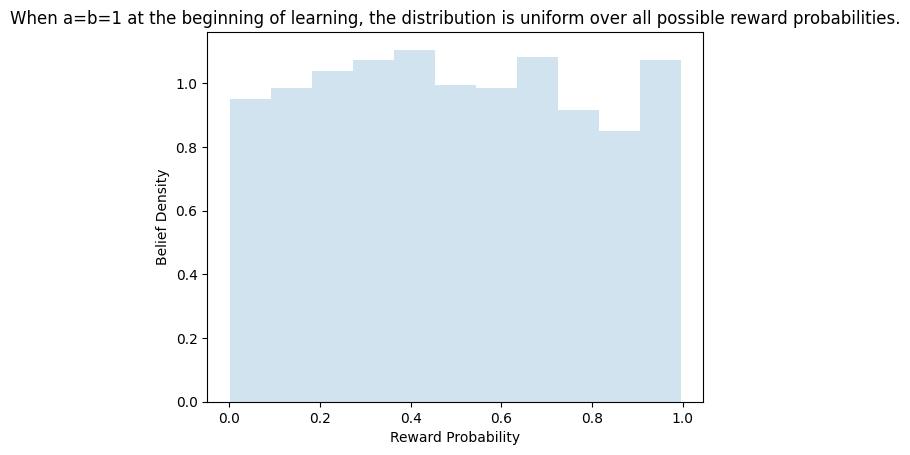

In [ ]:
# Define Beta distribution
# 
def beta_dist(a, b):
    '''
    The Beta distribution will represent the person's beliefs about the reward probability.
    '''
    return st.beta(a, b)

# Sample from the initial belief distribution
init_samples = beta_dist(1,1).rvs(size=1000)

fig, ax = plt.subplots(1, 1)
ax.hist(init_samples, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_title("When a=b=1 at the beginning of learning, the distribution is uniform over all possible reward probabilities.")
ax.set_xlabel("Reward Probability")
ax.set_ylabel("Belief Density")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3569eb68-a6a6-4122-9c3d-498e88f49235' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>